## Fast Bayesian estimation of SARIMAX models pymc3

In [1]:
%load_ext lab_black

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm
import theano
import theano.tensor as tt
from pandas.plotting import register_matplotlib_converters
from pandas_datareader.data import DataReader

plt.style.use("seaborn")
register_matplotlib_converters()

In [18]:
cpi = DataReader("CPIAUCNS", "fred", start="1971-01", end="2018-12")
cpi.index = pd.DatetimeIndex(cpi.index, freq="MS")

# Define the inflation series that we'll use in analysis
inf = np.log(cpi).resample("QS").mean().diff()[1:] * 400
inf = inf.dropna()
print(inf.head())

            CPIAUCNS
DATE                
1971-04-01  4.316424
1971-07-01  4.279518
1971-10-01  1.956799
1972-01-01  2.917767
1972-04-01  3.219096


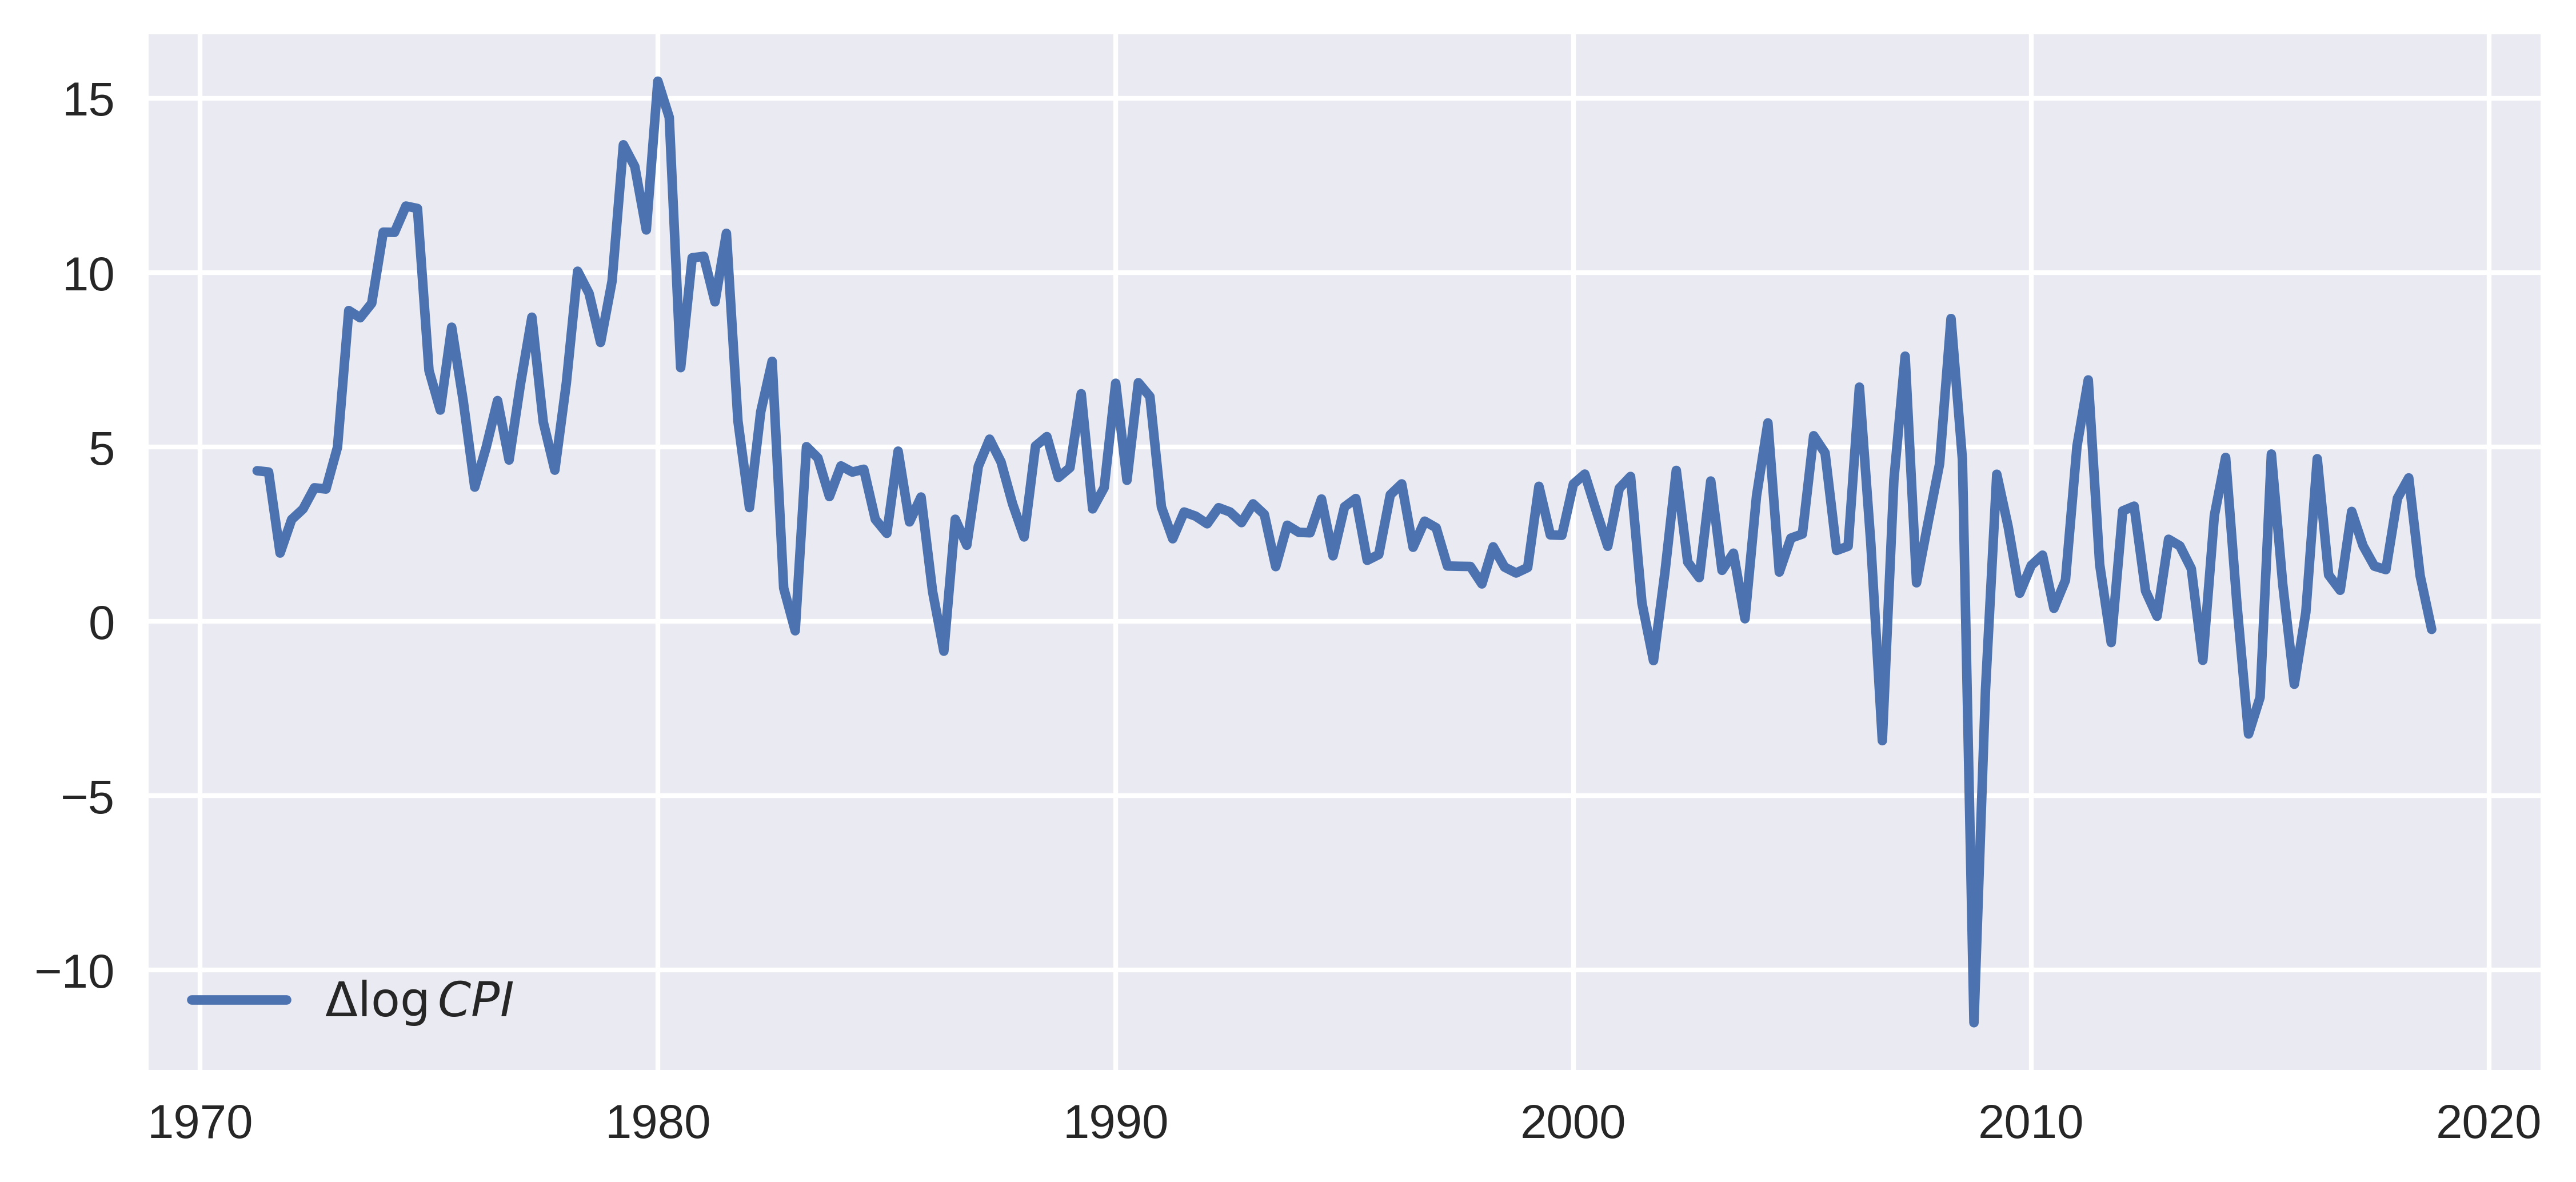

In [19]:
# Plot the series
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
ax.plot(inf.index, inf, label=r"$\Delta \log CPI$", lw=2)
ax.legend(loc="lower left")
plt.show()

In [20]:
# Create an SARIMAX model instance - here we use it to estimate
# the parameters via MLE using the `fit` method, but we can
# also re-use it below for the Bayesian estimation
mod = sm.tsa.statespace.SARIMAX(inf, order=(1, 0, 1))

res_mle = mod.fit(disp=False)
print(res_mle.summary())

                               SARIMAX Results                                
Dep. Variable:               CPIAUCNS   No. Observations:                  191
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -448.685
Date:                Tue, 27 Jul 2021   AIC                            903.370
Time:                        15:01:35   BIC                            913.127
Sample:                    04-01-1971   HQIC                           907.322
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9785      0.015     64.545      0.000       0.949       1.008
ma.L1         -0.6342      0.057    -11.073      0.000      -0.747      -0.522
sigma2         6.3682      0.323     19.695      0.0

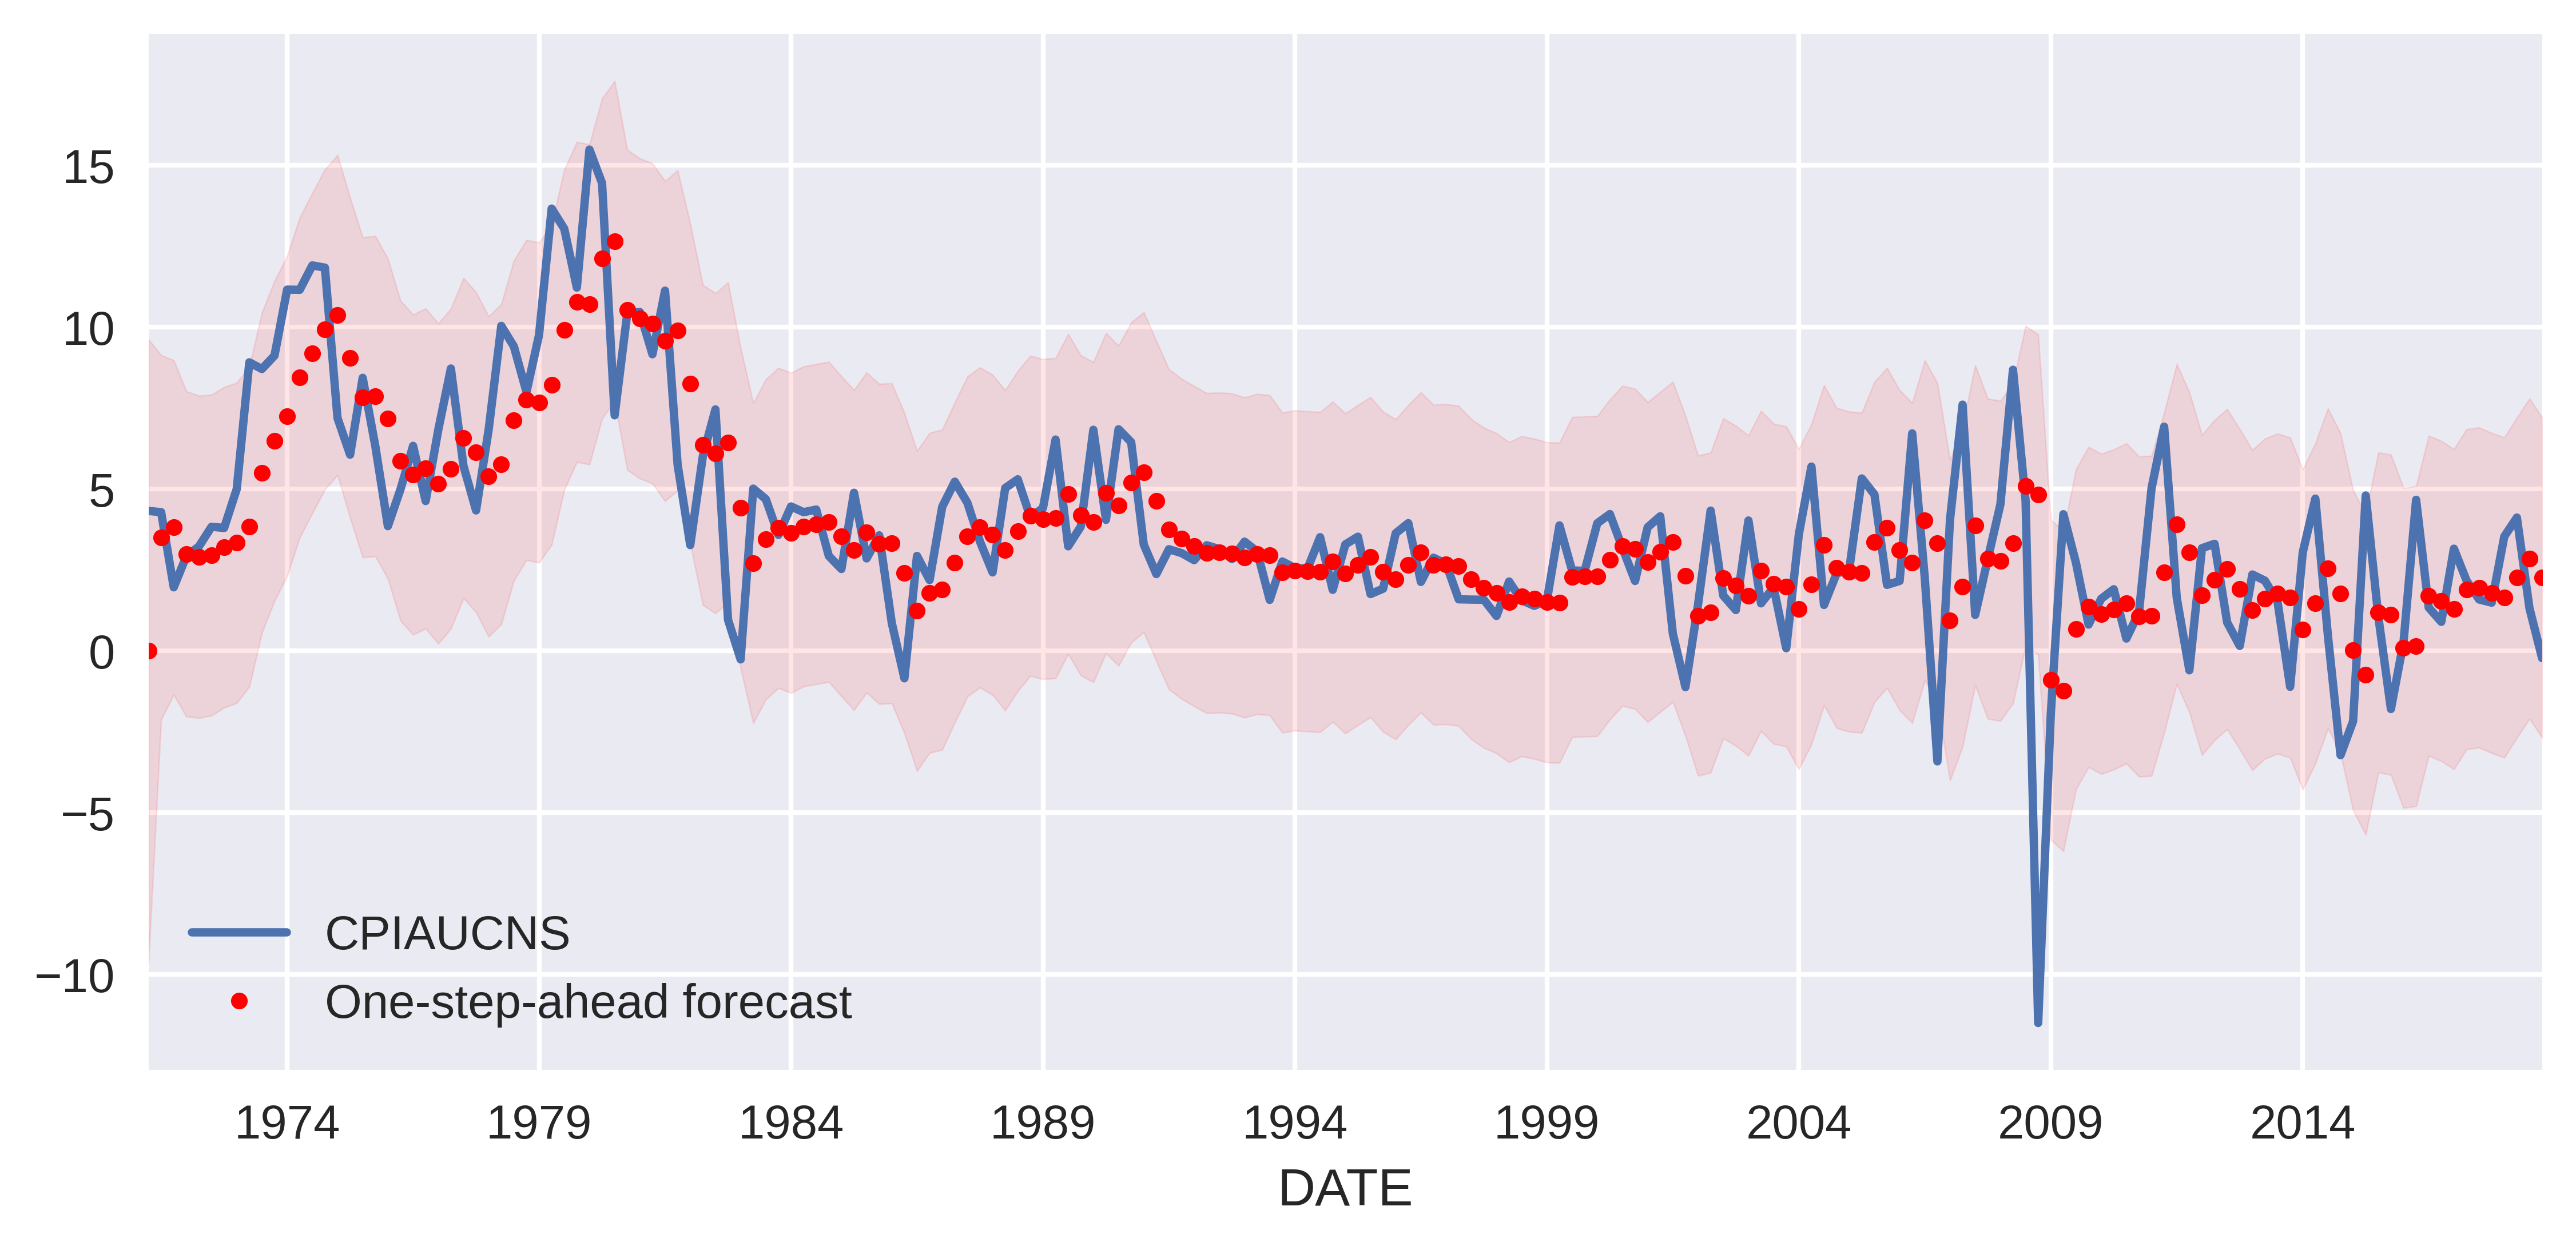

In [21]:
predict_mle = res_mle.get_prediction()
predict_mle_ci = predict_mle.conf_int()
lower = predict_mle_ci["lower CPIAUCNS"]
upper = predict_mle_ci["upper CPIAUCNS"]

# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
inf.plot(ax=ax, style="-", label="Observed")

# Plot predictions
predict_mle.predicted_mean.plot(ax=ax, style="r.", label="One-step-ahead forecast")
ax.fill_between(predict_mle_ci.index, lower, upper, color="r", alpha=0.1)
ax.legend(loc="lower left")
plt.show()

In [22]:
class Loglike(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        (theta,) = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf)  # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        (theta,) = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        (theta,) = inputs
        outputs[0][0] = self.model.score(theta)

In [23]:
# Set sampling params
ndraws = 3000  # number of draws from the distribution
nburn = 600  # number of "burn-in points" (which will be discarded)

In [24]:
# Construct an instance of the Theano wrapper defined above, which
# will allow PyMC3 to compute the likelihood and Jacobian in a way
# that it can make use of. Here we are using the same model instance
# created earlier for MLE analysis (we could also create a new model
# instance if we preferred)
loglike = Loglike(mod)

with pm.Model() as m:
    # Priors
    arL1 = pm.Uniform("ar.L1", -0.99, 0.99)
    maL1 = pm.Uniform("ma.L1", -0.99, 0.99)
    sigma2 = pm.InverseGamma("sigma2", 2, 4)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, maL1, sigma2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", loglike, observed=theta)

    # Draw samples
    trace = pm.sample(
        ndraws,
        tune=nburn,
        return_inferencedata=True,
        cores=1,
        compute_convergence_checks=False,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma2, ma.L1, ar.L1]


Sampling 1 chain for 600 tune and 1_328 draw iterations (600 + 1_328 draws total) took 100 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8823279008907002, but should be close to 0.8. Try to increase the number of tuning steps.


In [25]:
plt.tight_layout()
# Note: the syntax here for the lines argument is required for
# PyMC3 versions >= 3.7
# For version <= 3.6 you can use lines=dict(res_mle.params) instead
_ = pm.plot_trace(
    trace,
    lines=[(k, {}, [v]) for k, v in dict(res_mle.params).items()],
    combined=True,
    figsize=(12, 12),
)

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7f004807b310>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/weakref.py", line 54, in _cb
    def _cb(arg):
KeyboardInterrupt: 
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/cffi/cparser.py", line 5, in <module>
    from . import _pycparser as pycparser
ImportError: cannot import name '_pycparser' from 'cffi' (/opt/conda/lib/python3.9/site-packages/cffi/__init__.py)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_65/1437181592.py", line 5, in <module>
    _ = pm.plot_trace(
  File "/opt/conda/lib/python3.9/site-packages/arviz/plots/traceplot.py", line 244, in plot_trace
    axes = plot(**trace_plot_args)
  File "/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py", line 247, in plot_trace
    ax = _plot_chains_mpl(
  File "/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py", li

TypeError: object of type 'NoneType' has no len()

<Figure size 576x396 with 0 Axes>

Error in callback <function flush_figures at 0x7f007247d1f0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
pm.summary(trace)

In [ ]:
# Retrieve the posterior means
params = pm.summary(trace)["mean"].values

# Construct results using these posterior means as parameter values
res_bayes = mod.smooth(params)

predict_bayes = res_bayes.get_prediction()
predict_bayes_ci = predict_bayes.conf_int()
lower = predict_bayes_ci["lower CPIAUCNS"]
upper = predict_bayes_ci["upper CPIAUCNS"]

# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
inf.plot(ax=ax, style="-", label="Observed")

# Plot predictions
predict_bayes.predicted_mean.plot(ax=ax, style="r.", label="One-step-ahead forecast")
ax.fill_between(predict_bayes_ci.index, lower, upper, color="r", alpha=0.1)
ax.legend(loc="lower left")
plt.show()

In [ ]:
# Construct the model instance
mod_uc = sm.tsa.UnobservedComponents(inf, "rwalk", autoregressive=1)

# Fit the model via maximum likelihood
res_uc_mle = mod_uc.fit()
print(res_uc_mle.summary())

In [ ]:
# Set sampling params
ndraws = 3000  # number of draws from the distribution
nburn = 600  # number of "burn-in points" (which will be discarded)

In [ ]:
# Here we follow the same procedure as above, but now we instantiate the
# Theano wrapper `Loglike` with the UC model instance instead of the
# SARIMAX model instance
loglike_uc = Loglike(mod_uc)

with pm.Model():
    # Priors
    sigma2level = pm.InverseGamma("sigma2.level", 1, 1)
    sigma2ar = pm.InverseGamma("sigma2.ar", 1, 1)
    arL1 = pm.Uniform("ar.L1", -0.99, 0.99)

    # convert variables to tensor vectors
    theta_uc = tt.as_tensor_variable([sigma2level, sigma2ar, arL1])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", loglike_uc, observed=theta_uc)

    # Draw samples
    trace_uc = pm.sample(
        ndraws,
        tune=nburn,
        return_inferencedata=True,
        cores=1,
        compute_convergence_checks=False,
    )

In [ ]:
plt.tight_layout()
# Note: the syntax here for the lines argument is required for
# PyMC3 versions >= 3.7
# For version <= 3.6 you can use lines=dict(res_mle.params) instead
_ = pm.plot_trace(
    trace_uc,
    lines=[(k, {}, [v]) for k, v in dict(res_uc_mle.params).items()],
    combined=True,
    figsize=(12, 12),
)

In [ ]:
pm.summary(trace_uc)

In [ ]:
# Retrieve the posterior means
params = pm.summary(trace_uc)["mean"].values

# Construct results using these posterior means as parameter values
res_uc_bayes = mod_uc.smooth(params)

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
inf["CPIAUCNS"].plot(ax=ax, style="-", label="Observed data")

# Plot estimate of the level term
res_uc_mle.states.smoothed["level"].plot(ax=ax, label="Smoothed level (MLE)")
res_uc_bayes.states.smoothed["level"].plot(ax=ax, label="Smoothed level (Bayesian)")

ax.legend(loc="lower left");